# Interpolar população municipal para cada mês e ano

## Carregar massa de dados

In [14]:
import pandas as pd
import numpy as np
from os import system
from scipy.interpolate import interp1d

In [15]:
!ls -a1 estimativa_dou_*.csv | tail -1

estimativa_dou_2023.csv


In [16]:
ultimo_ano = 2021

In [18]:
dados = pd.DataFrame()

for arq in ['estimativa_dou_2014-2021.csv', 'estimativa_dou_2022.csv', 'estimativa_dou_2023.csv']:
    
    if dados.empty:
        dados = pd.read_csv(arq, sep=';', 
                            dtype={'cod1': 'object', 'cod2': 'object', 'habitantes': 'int'})
    else:
        dados2 = pd.read_csv(arq, sep=';',
                             dtype={'cod1': 'object', 'cod2': 'object', 'habitantes': 'int'},
                             names=list(dados.columns.values))
        #dados = dados.append(dados2)
        dados = pd.concat([dados, dados2])

dados['codigo'] = dados[['cod1', 'cod2']].apply(lambda x: int(x[0] + x[1]), axis=1)
dados.head()

,ano,uf,cod1,cod2,nome,habitantes,codigo
0,2014,RO,11,00015,Alta Floresta D'Oeste,25652,1100015
1,2014,RO,11,00379,Alto Alegre dos Parecis,13884,1100379
2,2014,RO,11,00403,Alto Paraíso,19841,1100403
3,2014,RO,11,00346,Alvorada D'Oeste,17228,1100346
4,2014,RO,11,00023,Ariquemes,102860,1100023


In [19]:
dados.tail()

,ano,uf,cod1,cod2,nome,habitantes,codigo
5565,2023,GO,52,22302,Vila Propício,6061,5222302
5566,2023,GO,52,00175,Água Fria de Goiás,5959,5200175
5567,2023,GO,52,00209,Água Limpa,1737,5200209
5568,2023,GO,52,00258,Águas Lindas de Goiás,235479,5200258
5569,2023,DF,53,00108,Brasília,3150481,5300108


In [20]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55700 entries, 0 to 5569
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ano         55700 non-null  int64 
 1   uf          55700 non-null  object
 2   cod1        55700 non-null  object
 3   cod2        55700 non-null  object
 4   nome        55700 non-null  object
 5   habitantes  55700 non-null  int64 
 6   codigo      55700 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 3.4+ MB


## Testar interpolação de dados para um município

In [21]:
dados_mun = dados[dados['codigo'] == 1100023][['ano', 'habitantes']].copy()
dados_mun

,ano,habitantes
4,2014,102860
5574,2015,104401
11141,2016,105896
16711,2017,107345
22281,2018,106168
27851,2019,107863
33421,2020,109523
38991,2021,111148
4,2022,111633
4,2023,112685


In [22]:
# remover um ponto de dados no meio da amostra para testar o resultado
dados_mun.drop(dados_mun.loc[dados_mun['ano'] == 2016].index, axis=0, inplace=True)

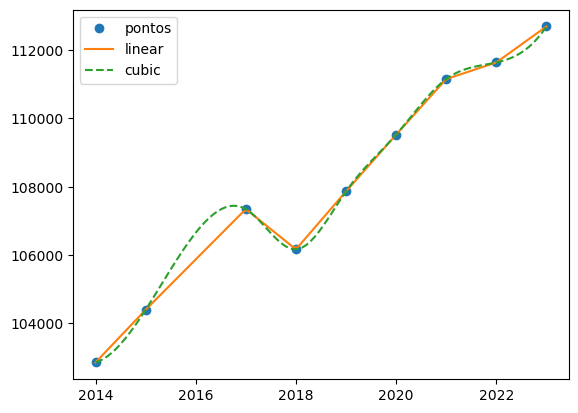

In [23]:
import matplotlib.pyplot as plt

x = dados_mun['ano']
y = dados_mun['habitantes']

f1 = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(min(x), max(x), num=(max(x)-min(x))*12, endpoint=True)

plt.plot(x, y, 'o')
plt.plot(xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['pontos', 'linear', 'cubic'], loc='best')
plt.show()

In [24]:
habitantes = np.round(f2(xnew)).astype(int)
habitantes

array([102860, 102906, 102972, 103057, 103158, 103276, 103407, 103552,
       103708, 103874, 104050, 104233, 104422, 104616, 104814, 105014,
       105215, 105415, 105613, 105808, 105999, 106184, 106361, 106529,
       106688, 106835, 106970, 107091, 107196, 107284, 107354, 107405,
       107435, 107443, 107427, 107387, 107320, 107228, 107117, 106992,
       106858, 106722, 106590, 106465, 106356, 106266, 106203, 106170,
       106175, 106218, 106294, 106400, 106532, 106684, 106852, 107032,
       107220, 107411, 107600, 107784, 107958, 108121, 108275, 108420,
       108559, 108692, 108823, 108951, 109079, 109208, 109340, 109476,
       109618, 109765, 109915, 110067, 110219, 110368, 110515, 110655,
       110788, 110913, 111026, 111127, 111214, 111288, 111350, 111401,
       111444, 111479, 111509, 111535, 111559, 111581, 111604, 111630,
       111659, 111694, 111736, 111786, 111847, 111919, 112004, 112104,
       112221, 112356, 112510, 112685])

## Interpolar dados para todos os municípios

In [25]:
#%%time

anos = []
meses = []
habitantes = []
cod1s = []
cod2s = []
ufs = []
nomes = []

for codigo in list(dados['codigo'].unique()):

    dados_mun = dados.loc[dados['codigo'] == codigo]
    row = dados_mun.iloc[0]

    x = dados_mun['ano']
    y = dados_mun['habitantes']

    menor_ano = min(x)
    maior_ano = max(x)

    #f1 = interp1d(x, y) # linear
    f2 = interp1d(x, y, kind='cubic') # cúbica

    xnew = np.linspace(menor_ano, maior_ano,
                       num=(maior_ano - menor_ano) * 12,
                       endpoint=True)
    ynew = np.round(f2(xnew)).astype(int)
    habitantes.extend(ynew.tolist())

    for ano in np.arange(menor_ano, maior_ano + 1):
        for mes in np.arange(1, 12 + 1):
            if (ano == menor_ano and mes < 7) or (ano == maior_ano and mes >= 7):
                continue
            anos.append(ano)
            meses.append(mes)
            
    qtde_meses = len(xnew)
    cod1s.extend([row['cod1']] * qtde_meses)
    cod2s.extend([row['cod2']] * qtde_meses)
    ufs.extend([row['uf']] * qtde_meses)
    nomes.extend([row['nome']] * qtde_meses)

In [26]:
dados_mes = pd.DataFrame({
    'ano': anos,
    'mes': meses,
    'uf': ufs,
    'cod1': cod1s,
    'cod2': cod2s,
    'nome': nomes,
    'habitantes': habitantes
})
dados_mes

,ano,mes,uf,cod1,cod2,nome,habitantes
0,2014,7,RO,11,00015,Alta Floresta D'Oeste,25652
1,2014,8,RO,11,00015,Alta Floresta D'Oeste,25675
2,2014,9,RO,11,00015,Alta Floresta D'Oeste,25690
3,2014,10,RO,11,00015,Alta Floresta D'Oeste,25698
4,2014,11,RO,11,00015,Alta Floresta D'Oeste,25700
...,...,...,...,...,...,...,...
601555,2023,2,DF,53,00108,Brasília,3138841
601556,2023,3,DF,53,00108,Brasília,3141506
601557,2023,4,DF,53,00108,Brasília,3144324
601558,2023,5,DF,53,00108,Brasília,3147310


# Gerar arquivos CSV com interpolações dos municípios

In [27]:
system('rm -f interpolacao_dou_*.csv.bz2')

0

In [28]:
menor = min(dados_mes['ano'])
maior = max(dados_mes['ano'])

csv = dados_mes.sort_values(['cod1', 'nome', 'ano', 'mes'])
csv.to_csv('interpolacao_dou_%d-%d.csv' % (menor, maior), sep=';', index=False, header=True)
csv.head()

,ano,mes,uf,cod1,cod2,nome,habitantes
0,2014,7,RO,11,00015,Alta Floresta D'Oeste,25652
1,2014,8,RO,11,00015,Alta Floresta D'Oeste,25675
2,2014,9,RO,11,00015,Alta Floresta D'Oeste,25690
3,2014,10,RO,11,00015,Alta Floresta D'Oeste,25698
4,2014,11,RO,11,00015,Alta Floresta D'Oeste,25700


In [29]:
system('bzip2 -9 interpolacao_dou_*.csv')

0